In [464]:
import hashlib   # 生成文件或者字符串的哈希值，数据的唯一标识，可以验证完整性和密码存储等
import os
import tarfile
import zipfile
import requests

In [465]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [466]:
def download(name, cache_dir=os.path.join('../DeepLearning/data', 'house price')):
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"

    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    
    with open(fname, 'wb') as f:
        f.write(r.content)
    
    return fname


In [467]:
def download_extract(name, folder=None):
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)

    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'

    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    for name in DATA_HUB:
        download(name)

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### load data

In [469]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [470]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [471]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [472]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


## data preprocessing

In [473]:
# test samples 和 training samples 要做相同的处理 针对缺失值

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

In [474]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

train_mean = train_data[numeric_features].mean()
train_std = train_data[numeric_features].std()

train_mean.shape, train_std.shape, numeric_features.shape

((36,), (36,), (36,))

In [475]:
# 防止test samples 泄漏， 需要对train samples 归一化后，用train_samples的统计量对 test sample 归一化
# 针对数值型数据

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

train_mean = train_data.iloc[:, 1:-1][numeric_features].mean()
train_std = train_data.iloc[:, 1:-1][numeric_features].std()

all_features[numeric_features] = (all_features[numeric_features] - train_mean) / train_std

all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [476]:
all_features.shape, all_features.iloc[0:5, [0, 1, 2, 3, -3, -2, -1]]

((2919, 79),
    MSSubClass MSZoning  LotFrontage   LotArea    YrSold SaleType SaleCondition
 0    0.073350       RL    -0.207948 -0.207071  0.138730       WD        Normal
 1   -0.872264       RL     0.409724 -0.091855 -0.614228       WD        Normal
 2    0.073350       RL    -0.084413  0.073455  0.138730       WD        Normal
 3    0.309753       RL    -0.413838 -0.096864 -1.367186       WD       Abnorml
 4    0.073350       RL     0.574436  0.375020  0.138730       WD        Normal)

In [477]:
# 处理离散型数据 转换为one-hot 编码, 必须test 和 train 一起处理
all_features = pd.get_dummies(all_features, dummy_na=True).astype(int)
all_features.shape, all_features.iloc[0:5, -4:-1]


((2919, 330),
    SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial
 0                     0                     1                      0
 1                     0                     1                      0
 2                     0                     1                      0
 3                     0                     0                      0
 4                     0                     1                      0)

In [478]:
# train_data 和 test_data 分离
n_train = train_data.shape[0]

train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [479]:
train_features.shape, train_labels.shape

(torch.Size([1460, 330]), torch.Size([1460, 1]))

## train models

In [480]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1)
                        )
    return net

In [481]:
def log_rmse(net, features, labels):
    # 为了取对数的时候稳定，小于1设为1, 0-1 log变化十分距离
    clipped_preds = torch.clamp(net(features), 1, float('inf'))

    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))

    return rmse.item()

In [482]:
def list_mean_safe(data):
    return sum(data) / len(data) if data else None

In [483]:
# 此处的test 均指validation 而不是上文的test
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [484]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [485]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.196643, 验证log rmse0.165098
折2，训练log rmse0.184816, 验证log rmse0.233469
折3，训练log rmse0.192468, 验证log rmse0.200989
折4，训练log rmse0.194351, 验证log rmse0.186593
折5，训练log rmse0.190960, 验证log rmse0.199539
5-折验证: 平均训练log rmse: 0.191847, 平均验证log rmse: 0.197138


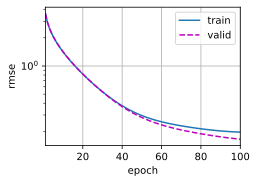

In [486]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [487]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.327307


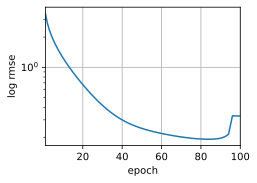

In [488]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)